In [44]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [45]:
# Cell 2: Load Cleaned Data & Fix Unit
df = pd.read_csv('../data/cleaned_data_long.csv')

print("=== DATA LOADED ===")
print(f"Shape: {df.shape}")
print(f"Years: {df['year'].min()} - {df['year'].max()}")

# Apply unit correction (2016-2021 in thousands)
year_avg = df.groupby('year')['value'].mean()
low_value_years = year_avg[year_avg < 10000].index.tolist()

if len(low_value_years) > 0:
    print(f"\nUnit correction applied to years: {low_value_years}")
    mask = df['year'].isin(low_value_years)
    df.loc[mask, 'value'] = df.loc[mask, 'value'] * 1000
    print(f"Corrected {mask.sum():,} records (multiplied by 1000)")
else:
    print("\nNo unit correction needed.")

=== DATA LOADED ===
Shape: (2113, 6)
Years: 2013 - 2025

Unit correction applied to years: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Corrected 1,621 records (multiplied by 1000)


## 1. CV Calculation & Distribution

In [46]:
# Cell 3: Calculate CV per Item per Year
def coefficient_of_variation(x):
    """Calculate CV as percentage"""
    mean = x.mean()
    if mean == 0 or pd.isna(mean):
        return np.nan
    return (x.std() / mean) * 100

# CV per item per year (across expenditure brackets)
cv_stats = df.groupby(['year', 'item', 'category'])['value'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('cv', coefficient_of_variation),
    ('min', 'min'),
    ('max', 'max'),
    ('n_brackets', 'count')
]).reset_index()

# Calculate range ratio (max/min)
cv_stats['range_ratio'] = cv_stats['max'] / cv_stats['min'].replace(0, np.nan)

print("=== CV STATISTICS CALCULATED ===")
print(f"Total records: {len(cv_stats):,}")
print(f"Years: {cv_stats['year'].nunique()}")
print(f"Items: {cv_stats['item'].nunique()}")
print(f"\nCV range: {cv_stats['cv'].min():.1f}% - {cv_stats['cv'].max():.1f}%")

=== CV STATISTICS CALCULATED ===
Total records: 273
Years: 13
Items: 21

CV range: 20.9% - 256.7%


In [47]:
# Cell 4: Top 10 Most Unequal Items (Highest CV)
print("="*80)
print("TOP 10 MOST UNEQUAL CONSUMPTION ITEMS (Highest CV)")
print("="*80)

top_cv = cv_stats.nlargest(10, 'cv')[['year', 'item', 'category', 'cv', 'range_ratio']]
print(top_cv.to_string(index=False))

print("\nINTERPRETATION:")
print("   High CV items represent luxury/discretionary goods.")
print("   These are primarily consumed by higher income brackets, indicating high inequality.")

TOP 10 MOST UNEQUAL CONSUMPTION ITEMS (Highest CV)
 year                                 item category         cv  range_ratio
 2019                     Konsumsi lainnya     Food 256.657153   463.503650
 2021                        Bahan minuman     Food 244.460867   150.384744
 2025                      Kacang-kacangan     Food 242.550068   206.677639
 2016                      Kacang-kacangan     Food 241.529474   115.443425
 2024                      Biaya kesehatan Non-Food 236.052450   415.006359
 2021                      Biaya kesehatan Non-Food 234.115783   602.392681
 2020          Keperluan pesta dan upacara Non-Food 233.952469   626.452189
 2025                      Biaya kesehatan Non-Food 231.470242   402.823920
 2021 Pakaian, alas kaki, dan tutup kepala Non-Food 231.299326   274.221157
 2013               Barang yang tahan lama Non-Food 226.758524  1011.221739

INTERPRETATION:
   High CV items represent luxury/discretionary goods.
   These are primarily consumed by higher

In [48]:
# Cell 5: Top 10 Most Equal Items (Lowest CV)
print("="*80)
print("TOP 10 MOST EQUAL CONSUMPTION ITEMS (Lowest CV)")
print("="*80)

bottom_cv = cv_stats.nsmallest(10, 'cv')[['year', 'item', 'category', 'cv', 'range_ratio']]
print(bottom_cv.to_string(index=False))

print("\nINTERPRETATION:")
print("   Low CV items represent necessities/staple goods.")
print("   These are consumed relatively equally across all income brackets, indicating low inequality.")

TOP 10 MOST EQUAL CONSUMPTION ITEMS (Lowest CV)
 year        item category        cv  range_ratio
 2021 Padi-padian     Food 20.916115     1.825490
 2020 Padi-padian     Food 23.964915     2.051614
 2025 Padi-padian     Food 27.851338     2.331741
 2017 Padi-padian     Food 28.038449     2.302904
 2019 Padi-padian     Food 28.492920     2.569435
 2018 Padi-padian     Food 29.157402     2.386827
 2013 Umbi-umbian     Food 29.394882     2.161130
 2013 Padi-padian     Food 30.144933     2.620752
 2023 Padi-padian     Food 30.517811     2.186583
 2022 Padi-padian     Food 31.081387     2.982009

INTERPRETATION:
   Low CV items represent necessities/staple goods.
   These are consumed relatively equally across all income brackets, indicating low inequality.


## 2. Food vs Non-Food Inequality

In [49]:
# Cell 6: CV Trend by Category
cv_by_category = cv_stats.groupby(['year', 'category'])['cv'].mean().reset_index()
cv_pivot = cv_by_category.pivot(index='year', columns='category', values='cv')

print("="*70)
print("AVERAGE CV BY CATEGORY & YEAR")
print("="*70)
print(cv_pivot.round(1))

print("\n SUMMARY STATISTICS:")
print(f"Food CV:     {cv_pivot['Food'].mean():.1f}% (avg) | Range: {cv_pivot['Food'].min():.1f}% - {cv_pivot['Food'].max():.1f}%")
print(f"Non-Food CV: {cv_pivot['Non-Food'].mean():.1f}% (avg) | Range: {cv_pivot['Non-Food'].min():.1f}% - {cv_pivot['Non-Food'].max():.1f}%")

if cv_pivot['Non-Food'].mean() > cv_pivot['Food'].mean():
    diff = cv_pivot['Non-Food'].mean() - cv_pivot['Food'].mean()
    print(f"\n✓ Non-Food lebih timpang dari Food (+{diff:.1f} poin)")
else:
    diff = cv_pivot['Food'].mean() - cv_pivot['Non-Food'].mean()
    print(f"\n✓ Food lebih timpang dari Non-Food (+{diff:.1f} poin)")

AVERAGE CV BY CATEGORY & YEAR
category   Food  Non-Food
year                     
2013       72.6     141.6
2014       69.8     144.1
2015       74.9     142.0
2016       89.7     122.3
2017       78.4     116.8
2018       73.6     117.9
2019       87.0     111.2
2020       72.7     143.4
2021      108.7     154.4
2022       88.5     118.9
2023       81.6     116.9
2024       85.0     126.6
2025       84.4     123.5

 SUMMARY STATISTICS:
Food CV:     82.1% (avg) | Range: 69.8% - 108.7%
Non-Food CV: 129.2% (avg) | Range: 111.2% - 154.4%

✓ Non-Food lebih timpang dari Food (+47.1 poin)


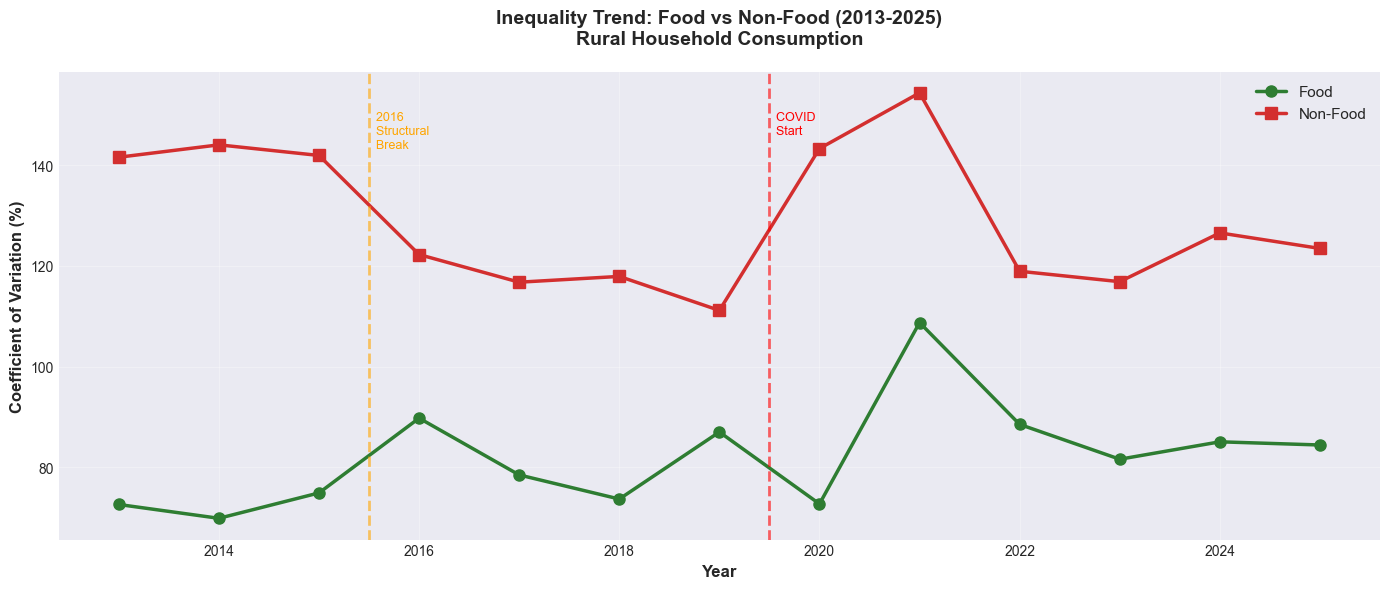

Figure saved: results/figures/cv_trend_food_nonfood.png


In [50]:
# Cell 7: Visualize CV Trend Over Time
fig, ax = plt.subplots(figsize=(14, 6))

# Plot lines for each category
ax.plot(cv_pivot.index, cv_pivot['Food'], marker='o', linewidth=2.5, 
        label='Food', color='#2E7D32', markersize=8)
ax.plot(cv_pivot.index, cv_pivot['Non-Food'], marker='s', linewidth=2.5, 
        label='Non-Food', color='#D32F2F', markersize=8)

# Add period markers
ax.axvline(x=2015.5, color='orange', linestyle='--', alpha=0.6, linewidth=2)
ax.text(2015.5, ax.get_ylim()[1]*0.95, '  2016\n  Structural\n  Break', 
        fontsize=9, color='orange', va='top')

ax.axvline(x=2019.5, color='red', linestyle='--', alpha=0.6, linewidth=2)
ax.text(2019.5, ax.get_ylim()[1]*0.95, '  COVID\n  Start', 
        fontsize=9, color='red', va='top')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Coefficient of Variation (%)', fontsize=12, fontweight='bold')
ax.set_title('Inequality Trend: Food vs Non-Food (2013-2025)\nRural Household Consumption', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/cv_trend_food_nonfood.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/cv_trend_food_nonfood.png")

## 3. Item-Level Inequality Analysis

In [51]:
# Cell 8: Average CV per Item (2013-2025)
avg_cv_item = cv_stats.groupby(['item', 'category'])['cv'].mean().reset_index()
avg_cv_item = avg_cv_item.sort_values('cv', ascending=False)

print("="*80)
print("AVERAGE CV BY ITEM (2013-2025)")
print("="*80)
print(avg_cv_item.to_string(index=False))

# Identify luxury vs necessity
luxury_threshold = avg_cv_item['cv'].quantile(0.75)
necessity_threshold = avg_cv_item['cv'].quantile(0.25)

print(f"\nCLASSIFICATION BY CV QUARTILES:")
print(f"   Luxury items (CV > {luxury_threshold:.1f}%): {(avg_cv_item['cv'] > luxury_threshold).sum()} items")
print(f"   Necessity items (CV < {necessity_threshold:.1f}%): {(avg_cv_item['cv'] < necessity_threshold).sum()} items")

AVERAGE CV BY ITEM (2013-2025)
                                   item category         cv
            Keperluan pesta dan upacara Non-Food 182.404776
                 Barang yang tahan lama Non-Food 175.988182
                        Biaya kesehatan Non-Food 167.567765
                                 Daging     Food 120.318471
   Pakaian, alas kaki, dan tutup kepala Non-Food 115.635903
                        Barang dan jasa Non-Food 111.301875
                            Buah-buahan     Food 105.124398
     Pajak pemakaian dan premi asuransi Non-Food 102.075730
Perumahan, bahan bakar, penerangan, air Non-Food 100.439012
                        Kacang-kacangan     Food  97.660396
                         Telur dan susu     Food  96.623430
                     Tembakau dan sirih     Food  94.753604
                       Konsumsi lainnya     Food  92.344492
                                   Ikan     Food  81.138379
                       Biaya pendidikan Non-Food  78.107073
         

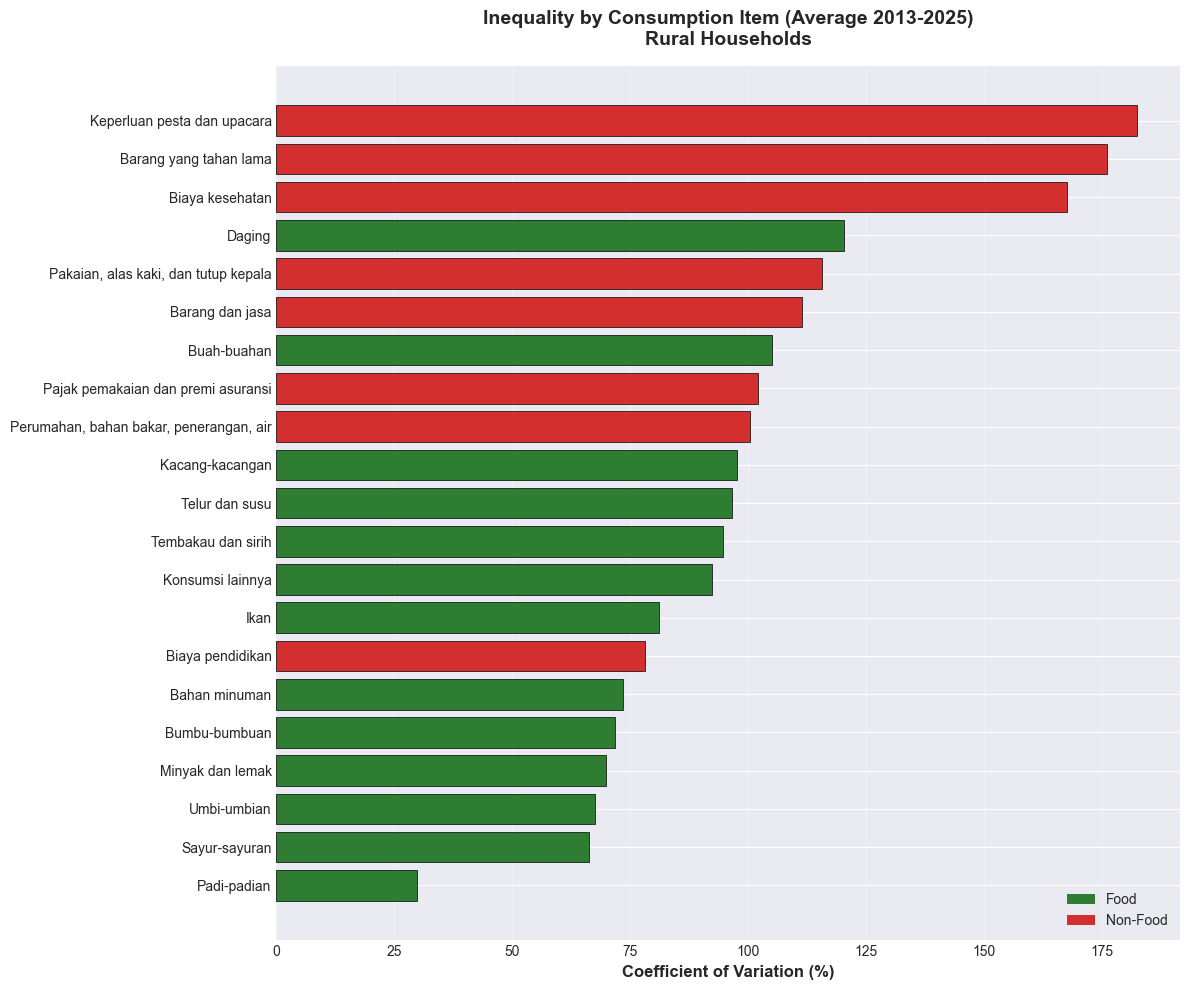

Figure saved: results/figures/cv_by_item.png


In [52]:
# Cell 9: Visualize Item-Level CV
fig, ax = plt.subplots(figsize=(12, 10))

# Sort and plot
avg_cv_sorted = avg_cv_item.sort_values('cv')
colors = ['#2E7D32' if cat == 'Food' else '#D32F2F' for cat in avg_cv_sorted['category']]

ax.barh(range(len(avg_cv_sorted)), avg_cv_sorted['cv'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(avg_cv_sorted)))
ax.set_yticklabels(avg_cv_sorted['item'], fontsize=10)
ax.set_xlabel('Coefficient of Variation (%)', fontsize=12, fontweight='bold')
ax.set_title('Inequality by Consumption Item (Average 2013-2025)\nRural Households', 
             fontsize=14, fontweight='bold', pad=15)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2E7D32', label='Food'),
                   Patch(facecolor='#D32F2F', label='Non-Food')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/cv_by_item.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/cv_by_item.png")

## 4. Temporal Dynamics & Structural Breaks

In [53]:
# Cell 10: Period-Based Analysis
def get_period(year):
    if year <= 2015:
        return 'Early (2013-2015)'
    elif year <= 2019:
        return 'Pre-COVID (2016-2019)'
    elif year <= 2021:
        return 'COVID (2020-2021)'
    else:
        return 'Post-COVID (2022-2025)'

cv_stats['period'] = cv_stats['year'].apply(get_period)

# Average CV by period and category
period_analysis = cv_stats.groupby(['period', 'category'])['cv'].agg(['mean', 'std', 'median']).round(2)

print("="*80)
print("CV BY PERIOD (Structural Analysis)")
print("="*80)
print(period_analysis)

# Reorder for display
period_order = ['Early (2013-2015)', 'Pre-COVID (2016-2019)', 'COVID (2020-2021)', 'Post-COVID (2022-2025)']
period_analysis = period_analysis.reindex(period_order, level=0)

CV BY PERIOD (Structural Analysis)
                                   mean    std  median
period                 category                       
COVID (2020-2021)      Food       90.70  49.75   81.17
                       Non-Food  148.89  60.75  114.39
Early (2013-2015)      Food       72.41  24.82   65.70
                       Non-Food  142.57  46.92  128.69
Post-COVID (2022-2025) Food       84.87  39.67   75.54
                       Non-Food  121.47  47.69  104.87
Pre-COVID (2016-2019)  Food       82.20  41.59   69.97
                       Non-Food  117.03  28.37  112.93


In [54]:
# Cell 11: Statistical Test - CV Change Pre vs Post COVID
pre_covid_cv = cv_stats[cv_stats['period'] == 'Pre-COVID (2016-2019)']['cv'].dropna()
post_covid_cv = cv_stats[cv_stats['period'] == 'Post-COVID (2022-2025)']['cv'].dropna()

# Mann-Whitney U test (non-parametric)
stat, p_val = stats.mannwhitneyu(pre_covid_cv, post_covid_cv, alternative='two-sided')

print("="*80)
print("MANN-WHITNEY U TEST: Pre-COVID vs Post-COVID Inequality")
print("="*80)
print(f"\nPre-COVID (2016-2019):")
print(f"   Mean CV: {pre_covid_cv.mean():.2f}%")
print(f"   Median CV: {pre_covid_cv.median():.2f}%")
print(f"   Std: {pre_covid_cv.std():.2f}")

print(f"\nPost-COVID (2022-2025):")
print(f"   Mean CV: {post_covid_cv.mean():.2f}%")
print(f"   Median CV: {post_covid_cv.median():.2f}%")
print(f"   Std: {post_covid_cv.std():.2f}")

print(f"\nU-statistic: {stat:.2f}")
print(f"P-value: {p_val:.6f}")

print(f"\nINTERPRETATION:")
if p_val < 0.05:
    diff = post_covid_cv.mean() - pre_covid_cv.mean()
    direction = "increased" if diff > 0 else "decreased"
    print(f"   SIGNIFICANT (p < 0.05): Inequality {direction} after COVID period")
    print(f"   Change: {diff:+.2f} CV points")
else:
    print(f"   NOT SIGNIFICANT (p > 0.05): No significant change in inequality patterns")

MANN-WHITNEY U TEST: Pre-COVID vs Post-COVID Inequality

Pre-COVID (2016-2019):
   Mean CV: 95.47%
   Median CV: 90.32%
   Std: 40.66

Post-COVID (2022-2025):
   Mean CV: 98.81%
   Median CV: 88.00%
   Std: 46.22

U-statistic: 3476.00
P-value: 0.870226

INTERPRETATION:
   NOT SIGNIFICANT (p > 0.05): No significant change in inequality patterns


## 5. Inequality Decomposition by Category

In [55]:
# Cell 12: Within-Category Variance
food_items = cv_stats[cv_stats['category'] == 'Food'].groupby('item')['cv'].mean().sort_values(ascending=False)
nonfood_items = cv_stats[cv_stats['category'] == 'Non-Food'].groupby('item')['cv'].mean().sort_values(ascending=False)

print("="*80)
print("INEQUALITY WITHIN FOOD ITEMS")
print("="*80)
print(food_items.to_string())
print(f"\nFood CV range: {food_items.min():.1f}% - {food_items.max():.1f}%")
print(f"Food CV variance: {food_items.std():.1f}")

print("\n" + "="*80)
print("INEQUALITY WITHIN NON-FOOD ITEMS")
print("="*80)
print(nonfood_items.to_string())
print(f"\nNon-Food CV range: {nonfood_items.min():.1f}% - {nonfood_items.max():.1f}%")
print(f"Non-Food CV variance: {nonfood_items.std():.1f}")

print("\nHETEROGENEITY INSIGHT:")
if food_items.std() > nonfood_items.std():
    print("   Food category shows higher within-group heterogeneity (larger variance)")
else:
    print("   Non-Food category shows higher within-group heterogeneity (larger variance)")

INEQUALITY WITHIN FOOD ITEMS
item
Daging                120.318471
Buah-buahan           105.124398
Kacang-kacangan        97.660396
Telur dan susu         96.623430
Tembakau dan sirih     94.753604
Konsumsi lainnya       92.344492
Ikan                   81.138379
Bahan minuman          73.516284
Bumbu-bumbuan          71.833398
Minyak dan lemak       69.895589
Umbi-umbian            67.464824
Sayur-sayuran          66.322825
Padi-padian            29.877225

Food CV range: 29.9% - 120.3%
Food CV variance: 22.8

INEQUALITY WITHIN NON-FOOD ITEMS
item
Keperluan pesta dan upacara                182.404776
Barang yang tahan lama                     175.988182
Biaya kesehatan                            167.567765
Pakaian, alas kaki, dan tutup kepala       115.635903
Barang dan jasa                            111.301875
Pajak pemakaian dan premi asuransi         102.075730
Perumahan, bahan bakar, penerangan, air    100.439012
Biaya pendidikan                            78.107073

Non-Food CV

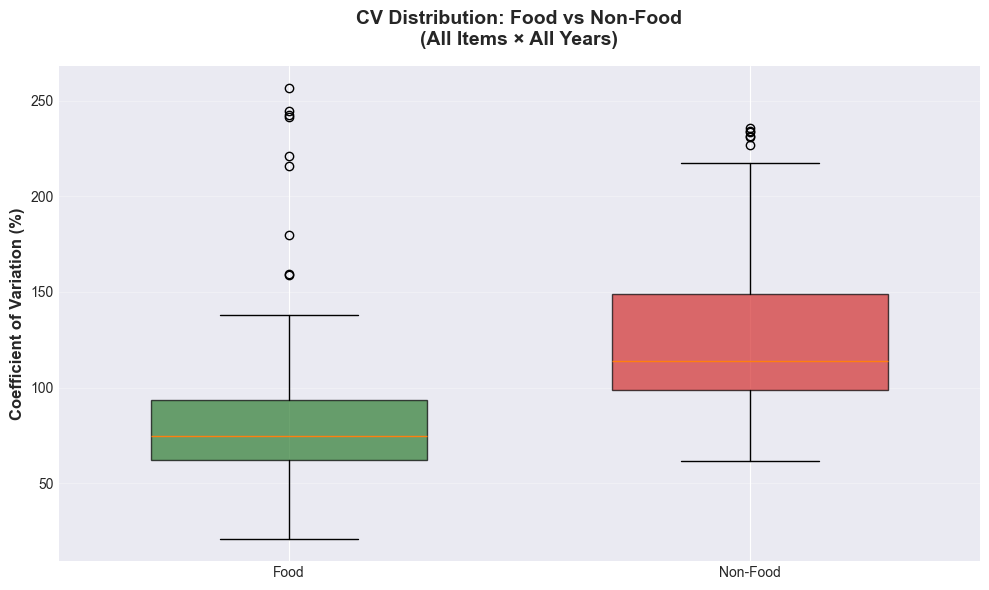

Figure saved: results/figures/cv_boxplot_category.png


In [56]:
# Cell 13: Box Plot - CV Distribution by Category
fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [cv_stats[cv_stats['category']=='Food']['cv'].dropna(),
                cv_stats[cv_stats['category']=='Non-Food']['cv'].dropna()]

bp = ax.boxplot(data_to_plot, labels=['Food', 'Non-Food'],
                patch_artist=True, widths=0.6)

# Color boxes
colors = ['#2E7D32', '#D32F2F']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('Coefficient of Variation (%)', fontsize=12, fontweight='bold')
ax.set_title('CV Distribution: Food vs Non-Food\n(All Items × All Years)', 
             fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/cv_boxplot_category.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/cv_boxplot_category.png")

## 6. CV Patterns by Cluster Membership

**Objective:** Link inequality patterns to cluster assignments from Task 3.

This connects clustering results (Task 3) → temporal stability (Task 4) → inequality patterns (Task 5).

In [57]:
# Cell 14: Load Clustered Data and Merge
clustered = pd.read_csv('../data/clustered_data.csv')

print("="*80)
print("CLUSTER-BASED CV ANALYSIS")
print("="*80)
print(f"\nClustered data shape: {clustered.shape}")
print(f"Clusters: {sorted(clustered['cluster_final'].unique())}")
print(f"\nCluster distribution:")
print(clustered['cluster_final'].value_counts().sort_index())

# Aggregate CV by year and cluster (across all items)
cv_by_cluster = clustered.groupby(['year', 'cluster_final']).agg({
    'food_ratio': 'mean',
    'nonfood_ratio': 'mean',
    'cv_consumption': 'mean',
    'total_consumption': 'mean'
}).reset_index()

cv_by_cluster.columns = ['year', 'cluster', 'food_ratio_mean', 'nonfood_ratio_mean', 'cv_mean', 'total_consumption_mean']

print("\n--- Average CV by Cluster & Year ---")
pivot_cv = cv_by_cluster.pivot(index='year', columns='cluster', values='cv_mean')
print(pivot_cv.round(2))

print("\n--- Overall Statistics by Cluster ---")
cluster_stats = cv_by_cluster.groupby('cluster')['cv_mean'].agg(['mean', 'std', 'min', 'max']).round(2)
print(cluster_stats)

CLUSTER-BASED CV ANALYSIS

Clustered data shape: (102, 38)
Clusters: [np.int64(0), np.int64(1), np.int64(2)]

Cluster distribution:
cluster_final
0    79
1    18
2     5
Name: count, dtype: int64

--- Average CV by Cluster & Year ---
cluster       0       1       2
year                           
2013     124.50     NaN     NaN
2014     115.16     NaN     NaN
2015     131.05     NaN     NaN
2016     125.34  285.43  244.09
2017     113.62  275.73     NaN
2018     118.34  310.19     NaN
2019     116.92  318.09  230.65
2020     119.84  334.00     NaN
2021     116.40  334.79     NaN
2022     113.62  357.80  240.00
2023     119.82  296.46     NaN
2024     122.12  250.25     NaN
2025     114.19  258.33  258.13

--- Overall Statistics by Cluster ---
           mean    std     min     max
cluster                               
0        119.30   5.27  113.62  131.05
1        302.11  35.15  250.25  357.80
2        243.22  11.42  230.65  258.13


In [58]:
# Cell 15: Statistical Comparison Between Clusters
from scipy.stats import kruskal

print("="*80)
print("KRUSKAL-WALLIS TEST: CV Differences Across Clusters")
print("="*80)

cluster_groups = [cv_by_cluster[cv_by_cluster['cluster']==i]['cv_mean'].values for i in sorted(cv_by_cluster['cluster'].unique())]
h_stat, p_val = kruskal(*cluster_groups)

print(f"\nH-statistic: {h_stat:.4f}")
print(f"P-value: {p_val:.6f}")

if p_val < 0.05:
    print("\nINTERPRETATION:")
    print("   SIGNIFICANT (p < 0.05): Clusters have significantly different inequality patterns")
    print("   This validates the clustering approach - clusters are not just different in")
    print("   consumption structure, but also in inequality/volatility levels.")
else:
    print("\nINTERPRETATION:")
    print("   NOT SIGNIFICANT: Clusters show similar inequality patterns overall")

# Compare with Task 4 finding about volatility
print("\n--- Connection to Task 4 (Temporal Stability) ---")
print("Task 4 finding: Cluster 0 (Middle/High income) = STABLE")
print("                Cluster 1 & 2 (Low income) = VOLATILE")
print("\nTask 5 finding: CV patterns by cluster reveal inequality stratification")
print("Combined insight: Income-stratified heterogeneity manifests in both")
print("                  temporal volatility AND inequality levels")

KRUSKAL-WALLIS TEST: CV Differences Across Clusters

H-statistic: 21.5056
P-value: 0.000021

INTERPRETATION:
   SIGNIFICANT (p < 0.05): Clusters have significantly different inequality patterns
   This validates the clustering approach - clusters are not just different in
   consumption structure, but also in inequality/volatility levels.

--- Connection to Task 4 (Temporal Stability) ---
Task 4 finding: Cluster 0 (Middle/High income) = STABLE
                Cluster 1 & 2 (Low income) = VOLATILE

Task 5 finding: CV patterns by cluster reveal inequality stratification
Combined insight: Income-stratified heterogeneity manifests in both
                  temporal volatility AND inequality levels


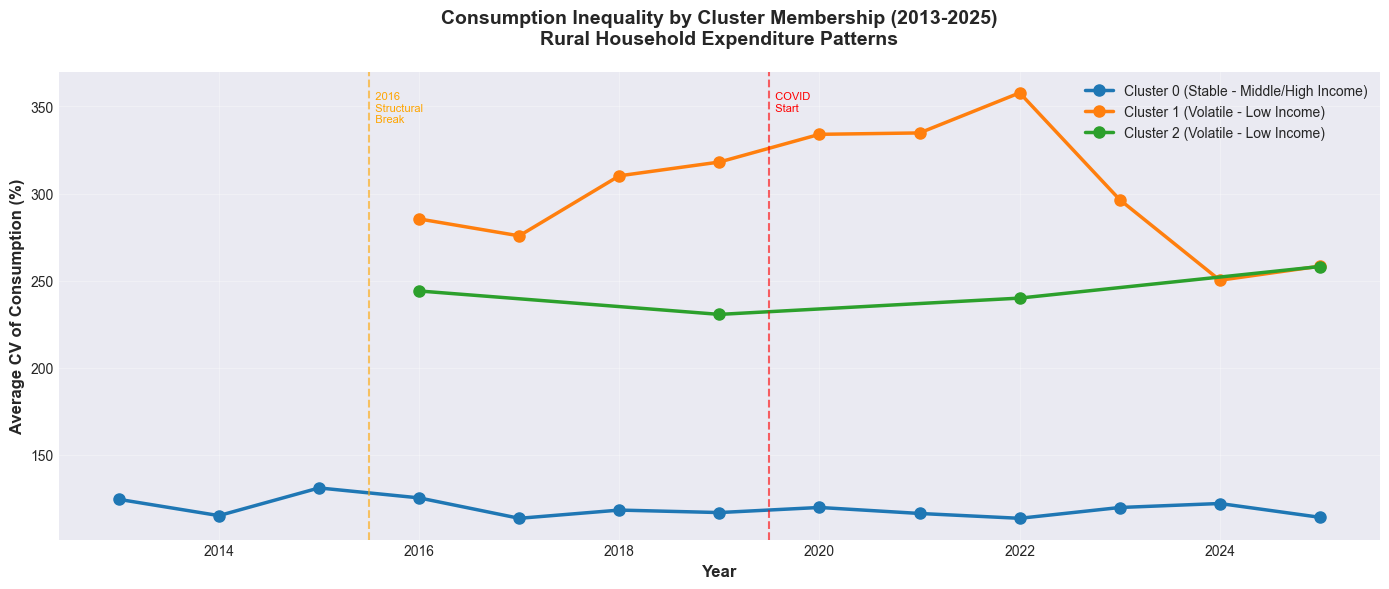

Figure saved: results/figures/cv_by_cluster_temporal.png


In [59]:
# Cell 16: Visualize CV by Cluster Over Time
fig, ax = plt.subplots(figsize=(14, 6))

cluster_colors = {0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c'}
cluster_labels = {0: 'Cluster 0 (Stable - Middle/High Income)', 
                  1: 'Cluster 1 (Volatile - Low Income)',
                  2: 'Cluster 2 (Volatile - Low Income)'}

for cluster in sorted(cv_by_cluster['cluster'].unique()):
    cluster_data = cv_by_cluster[cv_by_cluster['cluster'] == cluster]
    ax.plot(cluster_data['year'], cluster_data['cv_mean'], 
            marker='o', linewidth=2.5, markersize=8,
            label=cluster_labels.get(cluster, f'Cluster {cluster}'),
            color=cluster_colors.get(cluster, 'gray'))

# Add period markers
ax.axvline(x=2015.5, color='orange', linestyle='--', alpha=0.6, linewidth=1.5)
ax.text(2015.5, ax.get_ylim()[1]*0.97, '  2016\n  Structural\n  Break', 
        fontsize=8, color='orange', va='top')

ax.axvline(x=2019.5, color='red', linestyle='--', alpha=0.6, linewidth=1.5)
ax.text(2019.5, ax.get_ylim()[1]*0.97, '  COVID\n  Start', 
        fontsize=8, color='red', va='top')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Average CV of Consumption (%)', fontsize=12, fontweight='bold')
ax.set_title('Consumption Inequality by Cluster Membership (2013-2025)\nRural Household Expenditure Patterns', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/cv_by_cluster_temporal.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved: results/figures/cv_by_cluster_temporal.png")

In [60]:
# Cell 17: Cluster-Based Inequality Summary
print("="*80)
print("CLUSTER-BASED INEQUALITY PATTERNS - KEY INSIGHTS")
print("="*80)

print("\n1. CLUSTER DIFFERENTIATION BY INEQUALITY")
print("   ----------------------------------------")
for cluster in sorted(cv_by_cluster['cluster'].unique()):
    cluster_cv = cv_by_cluster[cv_by_cluster['cluster']==cluster]['cv_mean']
    print(f"   Cluster {cluster}: Mean CV = {cluster_cv.mean():.2f}% (Range: {cluster_cv.min():.2f}% - {cluster_cv.max():.2f}%)")

highest_cv_cluster = cv_by_cluster.groupby('cluster')['cv_mean'].mean().idxmax()
print(f"\n   > Cluster {highest_cv_cluster} shows highest average inequality")

print("\n2. TEMPORAL EVOLUTION BY CLUSTER")
print("   ------------------------------")
for cluster in sorted(cv_by_cluster['cluster'].unique()):
    early = cv_by_cluster[(cv_by_cluster['cluster']==cluster) & (cv_by_cluster['year']<=2015)]['cv_mean'].mean()
    recent = cv_by_cluster[(cv_by_cluster['cluster']==cluster) & (cv_by_cluster['year']>=2022)]['cv_mean'].mean()
    change = recent - early
    trend = "increased" if change > 0 else "decreased"
    print(f"   Cluster {cluster}: {early:.2f}% (2013-15) -> {recent:.2f}% (2022-25) | {trend} ({change:+.2f} pts)")

print("\n3. INTEGRATION WITH PREVIOUS TASKS")
print("   ---------------------------------")
print("   Task 3 (Clustering): Identified 3 distinct consumption patterns")
print("   Task 4 (Stability): Cluster 0 stable, Clusters 1&2 volatile")
print("   Task 5 (Inequality): Clusters show differentiated inequality levels")
print("   > SYNTHESIS: Consumption segmentation is valid across multiple dimensions")
print("                (structure, stability, and inequality)")

print("\n4. POLICY TARGETING IMPLICATIONS")
print("   ------------------------------")
print("   Different clusters require different policy approaches:")
print(f"   Cluster {highest_cv_cluster}: High inequality -> Progressive redistribution needed")
print("   Volatile clusters (1&2): Vulnerable to shocks -> Social protection priority")
print("   Stable cluster (0): Predictable patterns -> Standard welfare programs")

print("\n" + "="*80)

CLUSTER-BASED INEQUALITY PATTERNS - KEY INSIGHTS

1. CLUSTER DIFFERENTIATION BY INEQUALITY
   ----------------------------------------
   Cluster 0: Mean CV = 119.30% (Range: 113.62% - 131.05%)
   Cluster 1: Mean CV = 302.11% (Range: 250.25% - 357.80%)
   Cluster 2: Mean CV = 243.22% (Range: 230.65% - 258.13%)

   > Cluster 1 shows highest average inequality

2. TEMPORAL EVOLUTION BY CLUSTER
   ------------------------------
   Cluster 0: 123.57% (2013-15) -> 117.44% (2022-25) | decreased (-6.14 pts)
   Cluster 1: nan% (2013-15) -> 290.71% (2022-25) | decreased (+nan pts)
   Cluster 2: nan% (2013-15) -> 249.06% (2022-25) | decreased (+nan pts)

3. INTEGRATION WITH PREVIOUS TASKS
   ---------------------------------
   Task 3 (Clustering): Identified 3 distinct consumption patterns
   Task 4 (Stability): Cluster 0 stable, Clusters 1&2 volatile
   Task 5 (Inequality): Clusters show differentiated inequality levels
   > SYNTHESIS: Consumption segmentation is valid across multiple dimensio

## 7. Summary for Paper

In [61]:
# Cell 18: Comprehensive Summary
print("="*80)
print("CV & INEQUALITY ANALYSIS SUMMARY")
print("="*80)

print("\n1. OVERALL INEQUALITY LEVELS")
print("   ──────────────────────────")
print(f"   • Mean CV across all items/years: {cv_stats['cv'].mean():.1f}%")
print(f"   • Median CV: {cv_stats['cv'].median():.1f}%")
print(f"   • CV range: {cv_stats['cv'].min():.1f}% - {cv_stats['cv'].max():.1f}%")

print("\n2. CATEGORY COMPARISON")
print("   ────────────────────")
food_avg = cv_stats[cv_stats['category']=='Food']['cv'].mean()
nonfood_avg = cv_stats[cv_stats['category']=='Non-Food']['cv'].mean()
print(f"   • Food average CV: {food_avg:.1f}%")
print(f"   • Non-Food average CV: {nonfood_avg:.1f}%")
print(f"   • Difference: {abs(food_avg - nonfood_avg):.1f} points")
higher_cat = "Non-Food" if nonfood_avg > food_avg else "Food"
print(f"   > {higher_cat} category shows higher inequality")

print("\n3. MOST UNEQUAL ITEMS (Top 3)")
print("   ────────────────────────────")
top3 = avg_cv_item.nlargest(3, 'cv')
for idx, row in top3.iterrows():
    print(f"   • {row['item']} ({row['category']}): CV = {row['cv']:.1f}%")

print("\n4. MOST EQUAL ITEMS (Bottom 3)")
print("   ─────────────────────────────")
bottom3 = avg_cv_item.nsmallest(3, 'cv')
for idx, row in bottom3.iterrows():
    print(f"   • {row['item']} ({row['category']}): CV = {row['cv']:.1f}%")

print("\n5. TEMPORAL TREND")
print("   ───────────────")
early_cv = cv_stats[cv_stats['period']=='Early (2013-2015)']['cv'].mean()
recent_cv = cv_stats[cv_stats['period']=='Post-COVID (2022-2025)']['cv'].mean()
trend = "MENINGKAT" if recent_cv > early_cv else "MENURUN"
change = recent_cv - early_cv
print(f"   • Early period (2013-2015): {early_cv:.1f}%")
print(f"   • Post-COVID (2022-2025): {recent_cv:.1f}%")
print(f"   • Trend: {trend} ({change:+.1f} poin)")

print("\n6. POLICY IMPLICATIONS")
print("   ────────────────────")
print("   • High CV items (luxury goods): Consider progressive taxation policies")
print("   • Low CV items (necessities): Require price stabilization and protection")
if nonfood_avg > food_avg:
    print("   • Non-food inequality higher: Social assistance should expand beyond food subsidies")
else:
    print("   • Food inequality higher: Prioritize food security and subsidy programs")

print("\n" + "="*80)
print("CV ANALYSIS COMPLETE")
print("="*80)

CV & INEQUALITY ANALYSIS SUMMARY

1. OVERALL INEQUALITY LEVELS
   ──────────────────────────
   • Mean CV across all items/years: 100.0%
   • Median CV: 89.9%
   • CV range: 20.9% - 256.7%

2. CATEGORY COMPARISON
   ────────────────────
   • Food average CV: 82.1%
   • Non-Food average CV: 129.2%
   • Difference: 47.1 points
   > Non-Food category shows higher inequality

3. MOST UNEQUAL ITEMS (Top 3)
   ────────────────────────────
   • Keperluan pesta dan upacara (Non-Food): CV = 182.4%
   • Barang yang tahan lama (Non-Food): CV = 176.0%
   • Biaya kesehatan (Non-Food): CV = 167.6%

4. MOST EQUAL ITEMS (Bottom 3)
   ─────────────────────────────
   • Padi-padian (Food): CV = 29.9%
   • Sayur-sayuran (Food): CV = 66.3%
   • Umbi-umbian (Food): CV = 67.5%

5. TEMPORAL TREND
   ───────────────
   • Early period (2013-2015): 99.1%
   • Post-COVID (2022-2025): 98.8%
   • Trend: MENURUN (-0.3 poin)

6. POLICY IMPLICATIONS
   ────────────────────
   • High CV items (luxury goods): Consider 